In [24]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
import imageio
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output

PATCH_WIDTH = 128

In [25]:
path = ''
train_image_list = []
train_mask_list = []

N_AUGMENTS = 4 
for i in range(N_AUGMENTS + 1):
    rasters_path = fr"data\patches\train\augmentation_{i}\images"
    masks_path = fr"data\patches\train\augmentation_{i}\masks"
    train_image_list += [os.path.join(path, rasters_path, i) for i in os.listdir(os.path.join(path, rasters_path))]
    train_mask_list += [os.path.join(path, masks_path, i) for i in os.listdir(os.path.join(path, masks_path))]


test_path = r'data\patches\test'
test_image_list = [os.path.join(test_path, 'images', i) for i in os.listdir(os.path.join(test_path, 'images'))]
test_mask_list = [os.path.join(test_path, 'masks', i) for i in os.listdir(os.path.join(test_path, 'masks'))]


(128, 128, 3)
(128, 128, 3)


C:\Users\nazar\AppData\Local\Temp\ipykernel_10540\3626429126.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(train_image_list[N])
C:\Users\nazar\AppData\Local\Temp\ipykernel_10540\3626429126.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(train_mask_list[N])


Text(0.5, 1.0, 'Segmentation')

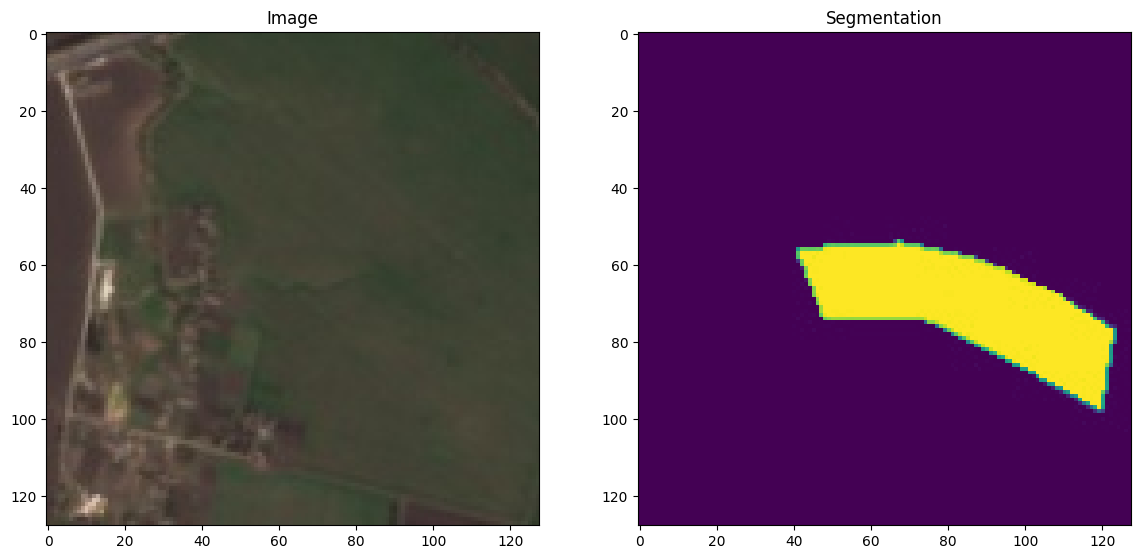

In [35]:
N = 10

img = imageio.imread(train_image_list[N])
mask = imageio.imread(train_mask_list[N])

print(img.shape)
print(mask.shape)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [27]:
train_image_filenames = tf.constant(train_image_list)
train_masks_filenames = tf.constant(train_mask_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_filenames, train_masks_filenames))

test_image_filenames = tf.constant(test_image_list)
test_masks_filenames = tf.constant(test_mask_list)

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_filenames, test_masks_filenames))

In [28]:
def process_path(image_path, mask_path):
    # Process images
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    # Process masks
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (PATCH_WIDTH, PATCH_WIDTH), method='nearest')
    input_mask = tf.image.resize(mask, (PATCH_WIDTH, PATCH_WIDTH), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

In [29]:
# Map pre-processing to both Datasets (images and masks)
train_image_ds = train_dataset.map(process_path)
processed_train_image_ds = train_image_ds.map(preprocess)

test_image_ds = test_dataset.map(process_path)
processed_test_image_ds = test_image_ds.map(preprocess)

In [30]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [39]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [40]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [58]:
OUTPUT_CLASSES = 1

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
TRAIN_LENGTH = len(train_image_list)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_batches = (
    processed_train_image_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = processed_test_image_ds.batch(BATCH_SIZE)

In [60]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(test_image_list)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches)

Epoch 1/20
212/212 [==============================] - 398s 2s/step - loss: 0.6370 - accuracy: 0.2577 - val_loss: 1.3979 - val_accuracy: 0.0229
Epoch 2/20
212/212 [==============================] - 379s 2s/step - loss: 0.5903 - accuracy: 0.2485 - val_loss: 1.7595 - val_accuracy: 9.3778e-05
Epoch 3/20
212/212 [==============================] - 391s 2s/step - loss: 0.6107 - accuracy: 0.2470 - val_loss: 1.6233 - val_accuracy: 9.3778e-05
Epoch 4/20
212/212 [==============================] - 401s 2s/step - loss: 0.6034 - accuracy: 0.3324 - val_loss: 1.3858 - val_accuracy: 0.1561
Epoch 5/20
212/212 [==============================] - 386s 2s/step - loss: 0.5738 - accuracy: 0.3050 - val_loss: 1.7006 - val_accuracy: 2.1569e-04
Epoch 6/20
212/212 [==============================] - 390s 2s/step - loss: 0.5776 - accuracy: 0.2920 - val_loss: 1.7181 - val_accuracy: 0.0186
Epoch 7/20
212/212 [==============================] - 384s 2s/step - loss: 0.6161 - accuracy: 0.3321 - val_loss: 1.2172 - val_accu

In [61]:
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model\assets


INFO:tensorflow:Assets written to: saved_model/my_model\assets
